# Developing an AI application

In this project, I'll train an image classifier to recognize different species of flowers. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories. Here are a few examples below 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

In [1]:
# Imports here
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise it can be [downloaded it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I'll apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64)

### Label mapping

I'll also need to load in a mapping from category label to category name. This is found in the file `cat_to_name.json`.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

I will use one of the pretrained models from `torchvision.models` to get the image features. Then I will build and train a new feed-forward classifier using those features.

To do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [5]:
# Load pre-trained network
model = models.vgg16(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 101896791.25it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [18]:
for param in model.parameters():
    # Freeze parameters
    param.requires_grad = False 
    

model.classifier = nn.Sequential(nn.Linear(25088, 516),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(516, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 106),
                                 nn.LogSoftmax(dim = 1))



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()

# Parameters of features network are left frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0001) 

model.to(device);

In [20]:
epochs = 10
steps = 0
running_loss = 0
print_every = 40

train_losses, valid_losses = [], []

for epoch in range(epochs):
    for train_inputs, train_labels in train_loader:
        steps += 1
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model.forward(train_inputs)
        loss = criterion(log_ps, train_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            valid_loss = 0
            valid_accuracy = 0
            
            model.eval()
            
            with torch.no_grad():
                for valid_inputs, valid_labels in valid_loader:

                    valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
    
                    log_ps = model.forward(valid_inputs)
                    valid_loss = criterion(log_ps, valid_labels).item()

                    ps = torch.exp(log_ps)
                    probs, classes = ps.topk(1, dim = 1)
                    equals = classes == valid_labels.view(*classes.shape)
                    valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
            train_losses.append(running_loss/len(train_loader))
            valid_losses.append(valid_loss/len(test_loader))
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Loss: {running_loss/print_every:.4f}.. "
                  f"Valid Loss: {valid_loss/len(valid_loader):.4f}.. "
                  f"Valid Accuracy: {valid_accuracy/len(valid_loader):.4f}..",)

            running_loss = 0
            model.train()
                    

Epoch 1/10.. Loss: 3.4338.. Valid Loss: 0.2576.. Valid Accuracy: 0.4493..
Epoch 1/10.. Loss: 2.8968.. Valid Loss: 0.2000.. Valid Accuracy: 0.5831..
Epoch 2/10.. Loss: 2.3724.. Valid Loss: 0.1795.. Valid Accuracy: 0.6466..
Epoch 2/10.. Loss: 2.0652.. Valid Loss: 0.1352.. Valid Accuracy: 0.7079..
Epoch 2/10.. Loss: 1.8777.. Valid Loss: 0.1189.. Valid Accuracy: 0.7625..
Epoch 3/10.. Loss: 1.6753.. Valid Loss: 0.1063.. Valid Accuracy: 0.8018..
Epoch 3/10.. Loss: 1.5313.. Valid Loss: 0.0888.. Valid Accuracy: 0.8131..
Epoch 4/10.. Loss: 1.4633.. Valid Loss: 0.0660.. Valid Accuracy: 0.8258..
Epoch 4/10.. Loss: 1.3095.. Valid Loss: 0.0769.. Valid Accuracy: 0.8479..
Epoch 4/10.. Loss: 1.2776.. Valid Loss: 0.0551.. Valid Accuracy: 0.8625..
Epoch 5/10.. Loss: 1.1612.. Valid Loss: 0.0565.. Valid Accuracy: 0.8687..
Epoch 5/10.. Loss: 1.1320.. Valid Loss: 0.0512.. Valid Accuracy: 0.8826..
Epoch 6/10.. Loss: 1.1273.. Valid Loss: 0.0422.. Valid Accuracy: 0.8718..
Epoch 6/10.. Loss: 1.0113.. Valid Loss

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

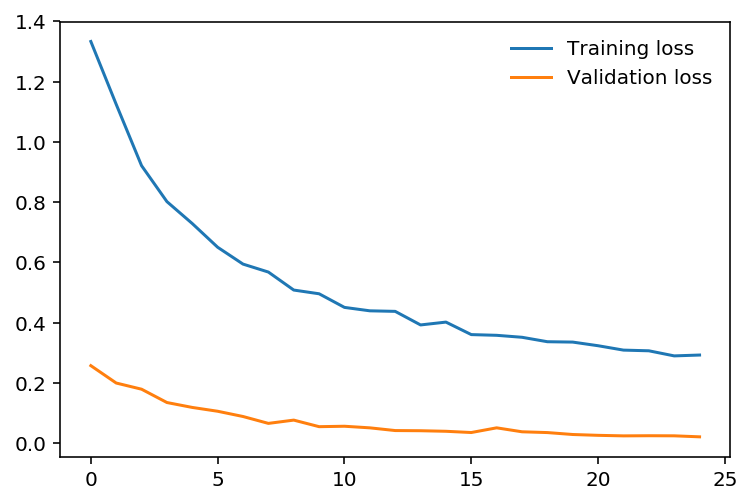

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [23]:
# Check accuracy after training is completed
test_loss = 0
test_accuracy = 0
model.eval()
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        
        log_ps = model.forward(test_inputs)
        batch_loss = criterion(log_ps, test_labels)
        test_loss += batch_loss.item()
        ps = torch.exp(log_ps)
        probs, classes = ps.topk(1, dim = 1)
        equals = classes == test_labels.view(*classes.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f'Loss: {test_loss/len(test_loader):.4f}, '
      f'Accuracy: {test_accuracy/len(test_loader):.4f}')
      
running_loss = 0

Loss: 0.4427, Accuracy: 0.8858


## Save the checkpoint

Now that the network is trained, I'll save the model so I can load it later for making predictions. 

In [24]:
checkpoint = {'epochs': 10,
              'learning_rate': 0.0001,
              'optimizer_state_dict': optimizer.state_dict(), 
              'criterion_state_dict': criterion.state_dict(),
              'class_to_idx': train_data.class_to_idx,
              'model_state_dict': model.state_dict()}
              
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

Now, I need to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [25]:
def load_checkpoint(filepath):
    
    rebuilt_model = models.vgg16(pretrained = True)
    
    for param in rebuilt_model.parameters():
        param.requires_grad = False
        
    rebuilt_model.classifier = nn.Sequential(nn.Linear(25088, 516),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(516, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 106),
                                 nn.LogSoftmax(dim = 1))

    rebuilt_checkpoint = torch.load(filepath)
    rebuilt_model.load_state_dict(rebuilt_checkpoint['model_state_dict'])
    model.epochs = rebuilt_checkpoint['epochs']
    learning_rate = rebuilt_checkpoint['learning_rate']
    rebuilt_model.class_to_idx = rebuilt_checkpoint['class_to_idx']

    return rebuilt_model

In [26]:
load_model = load_checkpoint('checkpoint.pth')
print(load_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [27]:
# Check accuracy of the loaded model
load_model.to(device);
valid_loss = 0
valid_accuracy = 0

load_model.eval() 

with torch.no_grad():
    for valid_inputs, valid_labels in valid_loader:

        valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
        log_ps = load_model.forward(valid_inputs)
        valid_loss = criterion(log_ps, valid_labels).item()

        ps = torch.exp(log_ps)
        probs, classes = ps.topk(1, dim = 1)
        equals = classes == valid_labels.view(*classes.shape)
        valid_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
print(f'Loss: {valid_loss/len(test_loader):.4f}, '
      f'Accuracy: {valid_accuracy/len(test_loader):.4f}')

Loss: 0.0279, Accuracy: 0.9185


# Inference for classification

Now I'll write a function to use a trained network for inference. I'll pass an image into the network and predict the class of the flower in the image. 

First I'll need to handle processing the input image such that it can be used in the network. 

## Image Preprocessing

I'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, I have to resize the images where the shortest side is 256 pixels, keeping the aspect ratio. Then I'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. I'll need to convert the values. It's easiest with a Numpy array.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. I'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. I can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [28]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    pil_image = Image.open(image)
    
    image_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    image_tensor = np.array(image_transforms(pil_image))
    return image_tensor

To check my work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [29]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

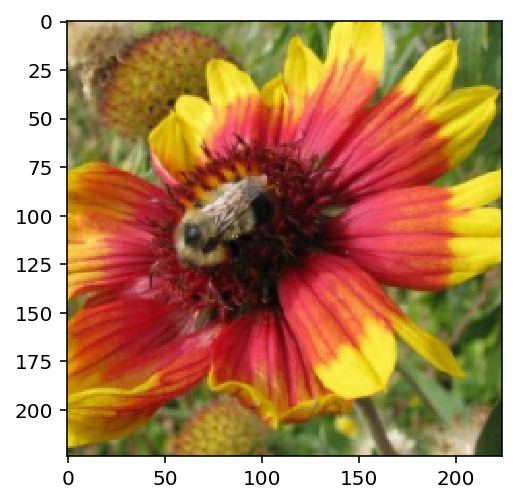

In [30]:
imshow(process_image('flowers/test/100/image_07896.jpg'))

## Class Prediction

Once the images are in the correct format,I will need to write a function for making predictions with the model. I'll need to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. 

In [31]:
def predict(image_path, load_model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Predict the class from an image file
    
    image = process_image(image_path)
    image = torch.from_numpy(np.asarray(image))
    image = image.unsqueeze(0)
    image = image.float()
    image = image.to(device)
 
    load_model.eval()

    with torch.no_grad():
        log_ps = load_model.forward(image)
        
    ps = torch.exp(log_ps)

    probs, classes = ps.topk(topk)
    probs = probs.to('cpu').numpy().tolist()[0]
    classes = classes.to('cpu').numpy().tolist()[0]

        
    # Create dictionary where classes and indexes are swapped
    reverse_class_to_idx = {j: k for k, j in load_model.class_to_idx.items()}

    # Take classes from reversed dictionary and converts it to a list
    top_classes = [reverse_class_to_idx[i] for i in classes]

    return probs, top_classes


In [32]:
probs, classes = predict('flowers/test/33/image_06479.jpg', load_model)
print(probs)
print(classes)

[0.43229302763938904, 0.08677542209625244, 0.08137515932321548, 0.06800391525030136, 0.027610909193754196]
['33', '84', '57', '67', '19']


## Sanity Checking

Now I will check the trained model to make sure the predictions make sense. 

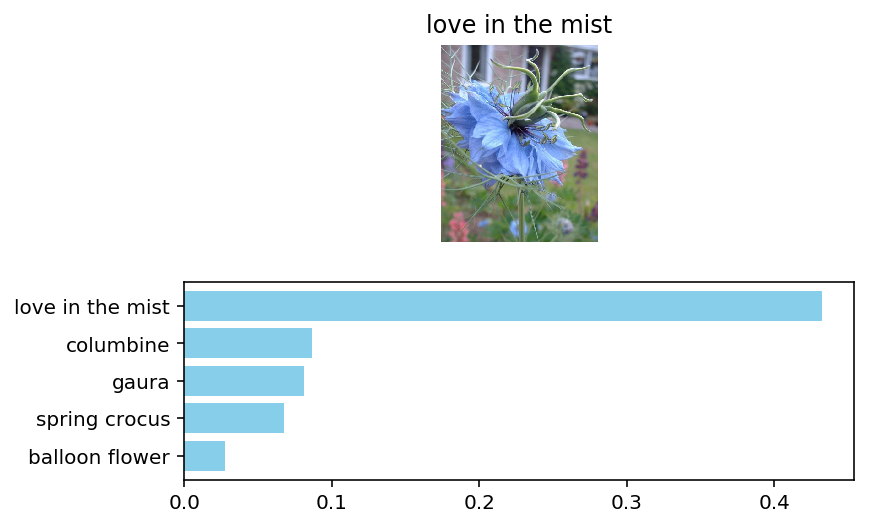

In [35]:
image_file_path = test_dir + '/33/image_06470.jpg'
sanity_probs, sanity_classes = predict(image_file_path, load_model)

label = classes[0]

fig, (image_ax, prob_ax) = plt.subplots(2,1)

display_image = Image.open(image_file_path)
image_ax.axis('off')
image_ax.set_title(cat_to_name[str(33)])
image_ax.imshow(display_image)


y_labels = []
for i in classes:
    y_labels.append(cat_to_name[i])

num_of_labels = np.arange(len(y_labels))
prob_ax.barh(num_of_labels, probs, align = 'center', color = 'skyblue', xerr = None)
prob_ax.set_yticks(num_of_labels)
prob_ax.set_yticklabels(y_labels)
prob_ax.invert_yaxis()